# Machine learning su aplicación en Biología

__Análisis de datos biológicos utilizando métodos de machine learning__

_MeIA_

`2023`

## Obtener los datos en ChEMBL

https://www.ebi.ac.uk/chembl/

## Pré tratamiento del conjunto de datos

1. Se eliminaron las moléculas sin datos de actividad;
2. Problemas en 'Standard Relation' (>, =, <);
3. Estandarice las columnas de 'Standard Units' (nM);
4. Eliminar columnas innecesarias;
5. Eliminar datos duplicados (IC50, Ki);
6. Estandarizar estructuras moleculares.

Usamos la biblioteca `Rdkit` (https://www.rdkit.org/) para calcular las propiedades moleculares de interés.

Esta página (https://www.rdkit.org/docs/Install.html) contiene instrucciones de instalación. Mi sugerencia es a través de conda:

- conda create -c conda-forge -n my-rdkit-env rdkit

- conda activate my-rdkit-env

También existe la opción de instalar a través de pip:

- pip install rdkit

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors
from rdkit import DataStructs
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Descriptors import MolWt
from rdkit.Chem.Descriptors import MolLogP
from rdkit.Chem.Descriptors import NumHAcceptors
from rdkit.Chem.Descriptors import NumHDonors
from rdkit.Chem import Lipinski
from rdkit.Chem import QED
from rdkit.Chem import MolSurf

En los ejemplos a continuación, usamos la notación de _smiles_ para calcular las propiedades moleculares. El siguiente enfoque consistió en:

1. Importar el conjunto de datos;

2. Eliminar moléculas que no cumplan la regla de Lipinski (biodisponibilidad oral);

3. Calcular los descriptores `QED` (drogasbilidad estimada), `MolWt` (masa molecular), `HeavyAtomCount` (número de átomos pesados), `NumRotatableBonds` (número de enlaces rotativos), `TPSA` (Área de superficie polar topológica) , `NumHAcceptors` (número de aceptores de hidrógeno) y `NumHDonors` (número de donantes de hidrógeno);

4. Eliminar descriptores correlacionados.

# Importación del conjunto de datos

In [2]:
ACHE = pd.read_csv('DB_ache_no_duplicates.csv', sep=';')
ACHE

,Unnamed: 0,Molecule ChEMBL ID,Smiles,Smiles_STAND,Standard Type,Standard Relation,Standard Value,Standard Units
0,0.0,CHEMBL3235210,N#C/C(=N\O)C(=O)NCC1CCN(Cc2ccccc2)CC1,N#CC(=NO)C(=O)NCC1CCN(Cc2ccccc2)CC1,Ki,'=',9.496300e+07,nM
1,1.0,CHEMBL1200970,CCN(CC)C(C)CN1c2ccccc2Sc2ccccc21.Cl,CCN(CC)C(C)CN1c2ccccc2Sc2ccccc21,Ki,'=',1.210000e+07,nM
2,3.0,CHEMBL1190,C[N+](C)(C)CCCCCCCCCC[N+](C)(C)C,C[N+](C)(C)CCCCCCCCCC[N+](C)(C)C,Ki,'=',6.000000e+06,nM
3,4.0,CHEMBL3235206,O=C(/C=N/O)NCC1CCN(Cc2ccccc2)CC1,O=C(C=NO)NCC1CCN(Cc2ccccc2)CC1,Ki,'=',3.178000e+06,nM
4,5.0,CHEMBL3235214,COc1cc2c(cc1OC)CN(CCCNC(=O)/C(=N/O)C(C)=O)CC2,COc1cc2c(cc1OC)CN(CCCNC(=O)C(=NO)C(C)=O)CC2,Ki,'=',2.671000e+06,nM
...,...,...,...,...,...,...,...,...
5488,6257.0,CHEMBL4210316,Cc1cccc(C(=O)N2Cc3cc(NC(=O)c4cccc(Cl)c4)ccc3CC...,Cc1cccc(C(=O)N2Cc3cc(NC(=O)c4cccc(Cl)c4)ccc3CC...,NaN,'''=''',1.441000e-02,nM
5489,6258.0,CHEMBL4217663,O=C(Nc1ccc2c(c1)CN(C(=O)c1cccc(Cl)c1)C(=O)C2)c...,O=C(Nc1ccc2c(c1)CN(C(=O)c1cccc(Cl)c1)C(=O)C2)c...,NaN,'''=''',1.415000e-02,nM
5490,6259.0,CHEMBL4209803,Cc1cccc(C(=O)Nc2ccc3c(c2)CN(C(=O)c2cccc(C)c2)C...,Cc1cccc(C(=O)Nc2ccc3c(c2)CN(C(=O)c2cccc(C)c2)C...,NaN,'''=''',1.352000e-02,nM
5491,6260.0,CHEMBL4205954,O=C(Nc1ccc2c(c1)CN(C(=O)c1ccccc1)C(=O)C2)c1ccc...,O=C(Nc1ccc2c(c1)CN(C(=O)c1ccccc1)C(=O)C2)c1ccc...,NaN,'''=''',1.323000e-02,nM


In [3]:
BACE = pd.read_csv('DB_bace_no_duplicates.csv', sep=';')
BACE

,Unnamed: 0,Molecule ChEMBL ID,Smiles,Smiles_STAND,Standard Type,Standard Relation,Standard Value,Standard Units,Molecule Name
0,0,CHEMBL2299399,CC(C)C[C@H](NCC(=O)[C@H](CC(N)=O)NC(=O)OC(C)(C...,CC(C)C[C@H](NCC(=O)C(CC(N)=O)NC(=O)OC(C)(C)C)[...,Ki,'=',10000.00,nM,NaN
1,1,CHEMBL2299401,CSCC[C@@H](NC(=O)[C@@H](NC(=O)OC(C)(C)C)C(C)C)...,CSCCC(NC(=O)C(NC(=O)OC(C)(C)C)C(C)C)C(=O)CN[C@...,Ki,'=',10000.00,nM,NaN
2,2,CHEMBL2299408,CSCC[C@@H](NC(=O)OC(C)(C)C)C(=O)CN[C@@H](CC(C)...,CSCCC(NC(=O)OC(C)(C)C)C(=O)CN[C@@H](CC(C)C)[C@...,Ki,'=',10000.00,nM,NaN
3,3,CHEMBL2299402,CC(C)C[C@H](NCC(=O)[C@H](CC(N)=O)NC(=O)OC(C)(C...,CC(C)C[C@H](NCC(=O)C(CC(N)=O)NC(=O)OC(C)(C)C)[...,Ki,'=',10000.00,nM,NaN
4,4,CHEMBL2299403,CC(C)C[C@H](NCC(=O)[C@H](CS(C)(=O)=O)NC(=O)OC(...,CC(C)C[C@H](NCC(=O)C(CS(C)(=O)=O)NC(=O)OC(C)(C...,Ki,'=',10000.00,nM,NaN
...,...,...,...,...,...,...,...,...,...
8035,10032,CHEMBL3695737,CN1C(=O)[C@]2(N=C1N)c1cc(-c3cccnc3F)ccc1Oc1c(F...,CN1C(=O)[C@]2(N=C1N)c1cc(-c3cccnc3F)ccc1Oc1c(F...,NaN,'=',0.20,nM,NaN
8036,10033,CHEMBL3741617,CC#CCOc1cnc(C(=O)Nc2ccc(F)c([C@]3(C)C[S@@]4(=O...,CC#CCOc1cnc(C(=O)Nc2ccc(F)c([C@]3(C)C[S@@]4(=O...,NaN,'=',0.20,nM,NaN
8037,10034,CHEMBL4588608,Cc1cc(C#N)cnc1C(=O)Nc1ccc(F)c([C@]2(C)CS3(=O)=...,Cc1cc(C#N)cnc1C(=O)Nc1ccc(F)c([C@]2(C)CS3(=O)=...,NaN,'=',0.20,nM,NaN
8038,10040,CHEMBL3680900,CC#CCOc1cnc(C(=O)Nc2ccc(F)c([C@@]3(C)N=C(N)OC[...,CC#CCOc1cnc(C(=O)Nc2ccc(F)c([C@@]3(C)N=C(N)OC[...,NaN,'=',0.10,nM,NaN


In [4]:
TAU = pd.read_csv('DB_tau_no_duplicates.csv', sep=';')
TAU

,Unnamed: 0,Molecule ChEMBL ID,Smiles,Smiles_STAND,Standard Type,Standard Relation,Standard Value,Standard Units
0,0,CHEMBL3593920,O=C1/C(=C\c2ccc([N+](=O)[O-])cc2)c2ccccc2N1Cc1...,O=C1/C(=C\c2ccc([N+](=O)[O-])cc2)c2ccccc2N1Cc1...,Ki,'=',1756.70,nM
1,1,CHEMBL2069430,CNc1ccc(C=C2C(=O)Nc3ccc(I)cc32)cc1,CNc1ccc(C=C2C(=O)Nc3ccc(I)cc32)cc1,Ki,'=',1428.00,nM
2,2,CHEMBL3593921,O=C1/C(=C/c2ccc([N+](=O)[O-])cc2)c2ccccc2N1Cc1...,O=C1/C(=C/c2ccc([N+](=O)[O-])cc2)c2ccccc2N1Cc1...,Ki,'=',1410.00,nM
3,3,CHEMBL3593898,CCOC(=O)N1C(=O)/C(=C\c2ccc(N(C)C)cc2)c2ccccc21,CCOC(=O)N1C(=O)/C(=C\c2ccc(N(C)C)cc2)c2ccccc21,Ki,'=',1116.20,nM
4,4,CHEMBL3593899,CN(C)c1ccc(/C=C2\C(=O)N(Cc3ccccc3)c3ncccc32)cc1,CN(C)c1ccc(/C=C2\C(=O)N(Cc3ccccc3)c3ncccc32)cc1,Ki,'=',858.80,nM
...,...,...,...,...,...,...,...,...
165,115,CHEMBL3286982,COc1cc(/C=c2\sc3nc(-c4ccc(Cl)cc4)cn3c2=O)cc(OC...,COc1cc(C=c2sc3nc(-c4ccc(Cl)cc4)cn3c2=O)cc(OC)c1O,IC50,'=',2.00,nM
166,116,CHEMBL3286983,COc1cc(/C=c2\sc3nc(-c4ccc(Cl)cc4)cn3c2=O)cc(Cl...,COc1cc(C=c2sc3nc(-c4ccc(Cl)cc4)cn3c2=O)cc(Cl)c1O,IC50,'=',2.00,nM
167,117,CHEMBL3286984,COc1cc(/C=c2\sc3nc(-c4ccc(Cl)cc4)cn3c2=O)cc(Br...,COc1cc(C=c2sc3nc(-c4ccc(Cl)cc4)cn3c2=O)cc(Br)c1O,IC50,'=',2.00,nM
168,118,CHEMBL2203332,CCCC[N+]1=C(/C=C/c2ccc(N(CC)CC)cc2)C(C)(C)c2cc...,CCCC[N+]1=C(/C=C/c2ccc(N(CC)CC)cc2)C(C)(C)c2cc...,IC50,'=',1.41,nM


# Comprobación de la cantidad de lunares activos e inactivos

## ACHE

In [5]:
ACHE.loc[ACHE['Standard Value'] > 500, 'Activity'] = 0 #inactives
ACHE.loc[ACHE['Standard Value'] <= 50, 'Activity'] = 1

In [6]:
pd.DataFrame(ACHE['Activity']).value_counts()

Activity
0.0         3626
1.0          852
dtype: int64

## BACE

In [7]:
BACE.loc[BACE['Standard Value'] > 500, 'Activity'] = 0 #inactives
BACE.loc[BACE['Standard Value'] <= 50, 'Activity'] = 1

In [8]:
pd.DataFrame(BACE['Activity']).value_counts()

Activity
0.0         3538
1.0         2366
dtype: int64

## TAU

In [9]:
TAU.loc[TAU['Standard Value'] > 500, 'Activity'] = 0 #inactives
TAU.loc[TAU['Standard Value'] <= 50, 'Activity'] = 1

In [10]:
pd.DataFrame(TAU['Activity']).value_counts()

Activity
0.0         93
1.0         32
dtype: int64

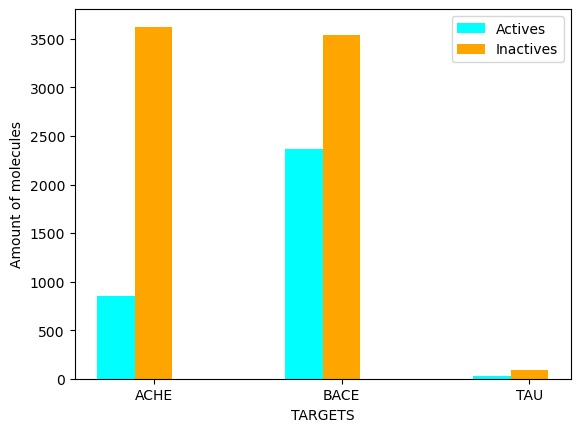

In [11]:
labels = ['ACHE', 'BACE', 'TAU']
actives = [852, 2366, 32]
inactives = [3626, 3538, 93]
width = 0.2
x = np.arange(3)

# plot data in grouped manner of bar type
plt.bar(x-0.2, actives, width, color='cyan')
plt.bar(x, inactives, width, color='orange')
plt.xticks(x, ['ACHE', 'BACE', 'TAU'])
plt.xlabel("TARGETS")
plt.ylabel("Amount of molecules")
plt.legend(["Actives", "Inactives"])
plt.show()

## Mass Filter

Lipinski's rule states that, in general, an orally active drug has no more than one violation of the following criteria:

    No more than 5 hydrogen bond donors (the total number of nitrogen–hydrogen and oxygen–hydrogen bonds)
    No more than 10 hydrogen bond acceptors (all nitrogen or oxygen atoms)
    A molecular mass less than 500 daltons
    An octanol-water partition coefficient[10] (log P) that does not exceed 5
    
--

Lipinski CA, Lombardo F, Dominy BW, Feeney PJ (March 2001). "Experimental and computational approaches to estimate solubility and permeability in drug discovery and development settings". Advanced Drug Delivery Reviews. 46 (1–3): 3–26. doi:10.1016/S0169-409X(00)00129-0

## ACHE

In [12]:
smiles_ache = []

for i in range(len(ACHE)):
    smiles_ache.append(ACHE["Smiles_STAND"][i])

In [13]:
descritors = {'MolWt':[], 'MolLogP':[], 'NumHAcceptors':[],'NumHDonors':[]}

In [14]:
for i in range(len(smiles_ache)):
    m = Chem.MolFromSmiles(smiles_ache[i])
    descritors['MolWt'].append(MolWt(m))
    descritors['MolLogP'].append(MolLogP(m))
    descritors['NumHAcceptors'].append(Lipinski.NumHAcceptors(m))
    descritors['NumHDonors'].append(Lipinski.NumHDonors(m))

In [15]:
dp_ache = pd.DataFrame(descritors)
dp_ache

,MolWt,MolLogP,NumHAcceptors,NumHDonors
0,300.362,1.36858,5,2
1,312.482,5.01960,3,0
2,258.494,3.51960,0,0
3,275.352,1.47480,4,2
4,363.414,0.98740,7,2
...,...,...,...,...
5488,418.880,4.62582,3,1
5489,439.298,4.97080,3,1
5490,398.462,4.28084,3,1
5491,404.853,4.31740,3,1


## BACE

In [16]:
smiles_bace = []

for i in range(len(BACE)):
    smiles_bace.append(BACE["Smiles_STAND"][i])

In [17]:
descritors = {'MolWt':[], 'MolLogP':[], 'NumHAcceptors':[],'NumHDonors':[]}

In [18]:
for i in range(len(smiles_bace)):
    m = Chem.MolFromSmiles(smiles_bace[i])
    descritors['MolWt'].append(MolWt(m))
    descritors['MolLogP'].append(MolLogP(m))
    descritors['NumHAcceptors'].append(Lipinski.NumHAcceptors(m))
    descritors['NumHDonors'].append(Lipinski.NumHDonors(m))

In [19]:
dp_bace = pd.DataFrame(descritors)
dp_bace

,MolWt,MolLogP,NumHAcceptors,NumHDonors
0,591.750,1.53670,8,6
1,778.114,5.21750,9,6
2,636.900,4.05050,8,5
3,619.804,2.17280,8,6
4,654.871,2.34200,9,5
...,...,...,...,...
8035,487.441,4.36390,6,1
8036,499.572,2.29240,8,2
8037,482.585,3.85937,6,3
8038,429.427,2.55840,7,2


## TAU

In [20]:
smiles_tau = []

for i in range(len(TAU)):
    smiles_tau.append(TAU["Smiles_STAND"][i])

In [21]:
descritors = {'MolWt':[], 'MolLogP':[], 'NumHAcceptors':[],'NumHDonors':[]}

In [22]:
for i in range(len(smiles_tau)):
    m = Chem.MolFromSmiles(smiles_tau[i])
    descritors['MolWt'].append(MolWt(m))
    descritors['MolLogP'].append(MolLogP(m))
    descritors['NumHAcceptors'].append(Lipinski.NumHAcceptors(m))
    descritors['NumHDonors'].append(Lipinski.NumHDonors(m))

In [23]:
dp_tau = pd.DataFrame(descritors)
dp_tau

,MolWt,MolLogP,NumHAcceptors,NumHDonors
0,356.381,4.6822,3,0
1,376.197,3.8256,2,2
2,356.381,4.6822,3,0
3,336.391,3.7963,4,0
4,355.441,4.2350,3,0
...,...,...,...,...
165,414.870,3.3469,7,1
166,419.289,3.9917,6,1
167,463.740,4.1008,6,1
168,375.580,6.4225,1,0


In [24]:
dp_tau['MolWt']

0      356.381
1      376.197
2      356.381
3      336.391
4      355.441
        ...   
165    414.870
166    419.289
167    463.740
168    375.580
169    414.870
Name: MolWt, Length: 170, dtype: float64

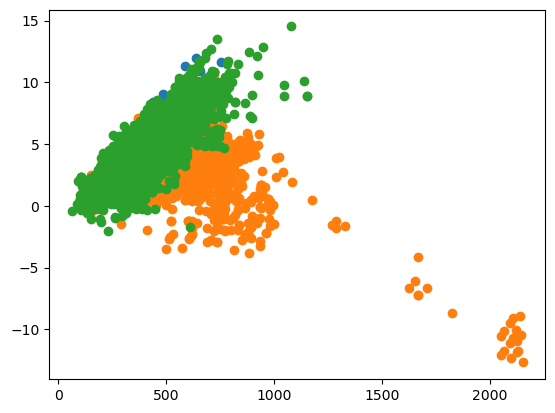

In [25]:
plt.scatter(dp_tau['MolWt'], dp_tau['MolLogP'])

plt.scatter(dp_bace['MolWt'], dp_bace['MolLogP'])

plt.scatter(dp_ache['MolWt'], dp_ache['MolLogP'])


plt.show()

## Eliminación de moléculas que no obedecen la regla de Lipinski

Las moléculas con peso molecular > 600 y LogP > 5 serán eliminadas

### ACHE

In [26]:
#Verificando as mols que não obedecem a regra
for i in range(len(dp_ache)):
    if dp_ache['MolWt'][i] > 600:
        if dp_ache['MolLogP'][i] > 5:
            print([i],'MolWt:', dp_ache['MolWt'][i], '-', 'MolLogP:', dp_ache['MolLogP'][i], '-',
              'NumHAcceptors:', dp_ache['NumHAcceptors'][i], '-', 'NumHDonors:', dp_ache['NumHDonors'][i])

[319] MolWt: 636.8700000000001 - MolLogP: 7.06610000000001 - NumHAcceptors: 6 - NumHDonors: 4
[377] MolWt: 713.7850000000002 - MolLogP: 5.122000000000004 - NumHAcceptors: 6 - NumHDonors: 2
[411] MolWt: 605.851 - MolLogP: 5.944200000000005 - NumHAcceptors: 6 - NumHDonors: 3
[480] MolWt: 631.8650000000001 - MolLogP: 8.607300000000006 - NumHAcceptors: 6 - NumHDonors: 1
[513] MolWt: 666.9920000000003 - MolLogP: 7.64580000000001 - NumHAcceptors: 6 - NumHDonors: 0
[514] MolWt: 666.9920000000003 - MolLogP: 7.64580000000001 - NumHAcceptors: 6 - NumHDonors: 0
[569] MolWt: 726.9190000000002 - MolLogP: 7.263020000000009 - NumHAcceptors: 8 - NumHDonors: 0
[603] MolWt: 681.9719999999999 - MolLogP: 8.722200000000004 - NumHAcceptors: 8 - NumHDonors: 2
[626] MolWt: 693.8929999999999 - MolLogP: 5.970500000000006 - NumHAcceptors: 8 - NumHDonors: 5
[631] MolWt: 695.0460000000003 - MolLogP: 8.426000000000007 - NumHAcceptors: 6 - NumHDonors: 0
[632] MolWt: 695.0460000000003 - MolLogP: 8.426000000000007 - N

[4954] MolWt: 695.735 - MolLogP: 10.533199999999992 - NumHAcceptors: 5 - NumHDonors: 2
[4967] MolWt: 641.7799999999999 - MolLogP: 6.322200000000006 - NumHAcceptors: 8 - NumHDonors: 3
[4987] MolWt: 700.2320000000002 - MolLogP: 7.733700000000008 - NumHAcceptors: 9 - NumHDonors: 2
[4991] MolWt: 601.7440000000001 - MolLogP: 5.828100000000005 - NumHAcceptors: 8 - NumHDonors: 1
[4992] MolWt: 636.2360000000002 - MolLogP: 8.487200000000003 - NumHAcceptors: 6 - NumHDonors: 2
[4998] MolWt: 657.7789999999999 - MolLogP: 6.253800000000005 - NumHAcceptors: 9 - NumHDonors: 3
[5011] MolWt: 645.8920000000002 - MolLogP: 8.901200000000003 - NumHAcceptors: 6 - NumHDonors: 2
[5014] MolWt: 733.9540000000004 - MolLogP: 10.004799999999998 - NumHAcceptors: 2 - NumHDonors: 0
[5015] MolWt: 681.708 - MolLogP: 10.143099999999993 - NumHAcceptors: 5 - NumHDonors: 2
[5016] MolWt: 653.6540000000001 - MolLogP: 9.362899999999998 - NumHAcceptors: 5 - NumHDonors: 2
[5022] MolWt: 667.6810000000002 - MolLogP: 9.752999999999

In [27]:
#Eliminando as mols que não obedecem a regra
for i in range(len(dp_ache)):
    if dp_ache['MolWt'][i] > 600:
        if dp_ache['MolLogP'][i] > 5:
            dp_ache.drop([i], axis=0,inplace = True)
            ACHE.drop([i], axis=0, inplace = True)

### BACE

In [28]:
for i in range(len(dp_bace)):
    if dp_bace['MolWt'][i] > 600:
        if dp_bace['MolLogP'][i] > 5:
            print([i],'MolWt:', dp_bace['MolWt'][i], '-', 'MolLogP:', dp_bace['MolLogP'][i], '-',
              'NumHAcceptors:', dp_bace['NumHAcceptors'][i], '-', 'NumHDonors:', dp_bace['NumHDonors'][i])

[1] MolWt: 778.1140000000001 - MolLogP: 5.2175000000000065 - NumHAcceptors: 9 - NumHDonors: 6
[52] MolWt: 764.0870000000001 - MolLogP: 5.175000000000005 - NumHAcceptors: 8 - NumHDonors: 6
[53] MolWt: 764.0870000000001 - MolLogP: 5.175000000000005 - NumHAcceptors: 8 - NumHDonors: 6
[54] MolWt: 764.0870000000001 - MolLogP: 5.175000000000005 - NumHAcceptors: 8 - NumHDonors: 6
[228] MolWt: 742.5540000000003 - MolLogP: 7.621099999999999 - NumHAcceptors: 18 - NumHDonors: 11
[230] MolWt: 601.817 - MolLogP: 7.926020000000008 - NumHAcceptors: 8 - NumHDonors: 1
[240] MolWt: 602.4600000000003 - MolLogP: 6.419000000000007 - NumHAcceptors: 14 - NumHDonors: 9
[564] MolWt: 627.8989999999999 - MolLogP: 8.911200000000003 - NumHAcceptors: 7 - NumHDonors: 1
[580] MolWt: 835.9710000000001 - MolLogP: 5.281400000000005 - NumHAcceptors: 8 - NumHDonors: 4
[618] MolWt: 613.872 - MolLogP: 8.138720000000008 - NumHAcceptors: 7 - NumHDonors: 1
[626] MolWt: 613.872 - MolLogP: 8.657220000000004 - NumHAcceptors: 7 - 

[5365] MolWt: 707.8400000000003 - MolLogP: 5.560200000000005 - NumHAcceptors: 7 - NumHDonors: 3
[5385] MolWt: 634.9060000000002 - MolLogP: 5.020800000000004 - NumHAcceptors: 5 - NumHDonors: 4
[5401] MolWt: 718.8859999999997 - MolLogP: 5.011000000000005 - NumHAcceptors: 6 - NumHDonors: 4
[5402] MolWt: 769.8640000000001 - MolLogP: 5.020400000000005 - NumHAcceptors: 9 - NumHDonors: 3
[5432] MolWt: 627.5680000000002 - MolLogP: 7.997300000000006 - NumHAcceptors: 5 - NumHDonors: 1
[5508] MolWt: 692.2560000000004 - MolLogP: 10.066799999999986 - NumHAcceptors: 7 - NumHDonors: 5
[5520] MolWt: 692.2560000000004 - MolLogP: 10.066799999999986 - NumHAcceptors: 7 - NumHDonors: 5
[5531] MolWt: 664.7939999999998 - MolLogP: 5.654000000000006 - NumHAcceptors: 7 - NumHDonors: 3
[5545] MolWt: 618.5350000000001 - MolLogP: 6.873880000000008 - NumHAcceptors: 6 - NumHDonors: 1
[5563] MolWt: 639.7960000000002 - MolLogP: 6.539000000000006 - NumHAcceptors: 5 - NumHDonors: 4
[5565] MolWt: 653.8230000000001 - MolL

In [29]:
for i in range(len(dp_bace)):
    if dp_bace['MolWt'][i] > 600:
        if dp_bace['MolLogP'][i] > 5:
            dp_bace.drop([i], axis=0)
            BACE.drop([i], axis=0)

In [30]:
BACE

,Unnamed: 0,Molecule ChEMBL ID,Smiles,Smiles_STAND,Standard Type,Standard Relation,Standard Value,Standard Units,Molecule Name,Activity
0,0,CHEMBL2299399,CC(C)C[C@H](NCC(=O)[C@H](CC(N)=O)NC(=O)OC(C)(C...,CC(C)C[C@H](NCC(=O)C(CC(N)=O)NC(=O)OC(C)(C)C)[...,Ki,'=',10000.00,nM,NaN,0.0
1,1,CHEMBL2299401,CSCC[C@@H](NC(=O)[C@@H](NC(=O)OC(C)(C)C)C(C)C)...,CSCCC(NC(=O)C(NC(=O)OC(C)(C)C)C(C)C)C(=O)CN[C@...,Ki,'=',10000.00,nM,NaN,0.0
2,2,CHEMBL2299408,CSCC[C@@H](NC(=O)OC(C)(C)C)C(=O)CN[C@@H](CC(C)...,CSCCC(NC(=O)OC(C)(C)C)C(=O)CN[C@@H](CC(C)C)[C@...,Ki,'=',10000.00,nM,NaN,0.0
3,3,CHEMBL2299402,CC(C)C[C@H](NCC(=O)[C@H](CC(N)=O)NC(=O)OC(C)(C...,CC(C)C[C@H](NCC(=O)C(CC(N)=O)NC(=O)OC(C)(C)C)[...,Ki,'=',10000.00,nM,NaN,0.0
4,4,CHEMBL2299403,CC(C)C[C@H](NCC(=O)[C@H](CS(C)(=O)=O)NC(=O)OC(...,CC(C)C[C@H](NCC(=O)C(CS(C)(=O)=O)NC(=O)OC(C)(C...,Ki,'=',10000.00,nM,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...
8035,10032,CHEMBL3695737,CN1C(=O)[C@]2(N=C1N)c1cc(-c3cccnc3F)ccc1Oc1c(F...,CN1C(=O)[C@]2(N=C1N)c1cc(-c3cccnc3F)ccc1Oc1c(F...,NaN,'=',0.20,nM,NaN,1.0
8036,10033,CHEMBL3741617,CC#CCOc1cnc(C(=O)Nc2ccc(F)c([C@]3(C)C[S@@]4(=O...,CC#CCOc1cnc(C(=O)Nc2ccc(F)c([C@]3(C)C[S@@]4(=O...,NaN,'=',0.20,nM,NaN,1.0
8037,10034,CHEMBL4588608,Cc1cc(C#N)cnc1C(=O)Nc1ccc(F)c([C@]2(C)CS3(=O)=...,Cc1cc(C#N)cnc1C(=O)Nc1ccc(F)c([C@]2(C)CS3(=O)=...,NaN,'=',0.20,nM,NaN,1.0
8038,10040,CHEMBL3680900,CC#CCOc1cnc(C(=O)Nc2ccc(F)c([C@@]3(C)N=C(N)OC[...,CC#CCOc1cnc(C(=O)Nc2ccc(F)c([C@@]3(C)N=C(N)OC[...,NaN,'=',0.10,nM,NaN,1.0


### TAU

In [31]:
for i in range(len(dp_tau)):
    if dp_tau['MolWt'][i] > 600:
        if dp_tau['MolLogP'][i] > 5:
            print([i],'MolWt:', dp_tau['MolWt'][i], '-', 'MolLogP:', dp_tau['MolLogP'][i], '-',
              'NumHAcceptors:', dp_tau['NumHAcceptors'][i], '-', 'NumHDonors:', dp_tau['NumHDonors'][i])

[86] MolWt: 654.886 - MolLogP: 10.93007999999999 - NumHAcceptors: 7 - NumHDonors: 1
[87] MolWt: 636.871 - MolLogP: 11.968359999999983 - NumHAcceptors: 7 - NumHDonors: 0
[149] MolWt: 755.1159999999996 - MolLogP: 11.679199999999984 - NumHAcceptors: 6 - NumHDonors: 0


In [32]:
for i in range(len(dp_tau)):
    if dp_tau['MolWt'][i] > 600:
        if dp_tau['MolLogP'][i] > 5:
            dp_tau.drop([i], axis=0)
            TAU.drop([i], axis=0)

In [33]:
TAU

,Unnamed: 0,Molecule ChEMBL ID,Smiles,Smiles_STAND,Standard Type,Standard Relation,Standard Value,Standard Units,Activity
0,0,CHEMBL3593920,O=C1/C(=C\c2ccc([N+](=O)[O-])cc2)c2ccccc2N1Cc1...,O=C1/C(=C\c2ccc([N+](=O)[O-])cc2)c2ccccc2N1Cc1...,Ki,'=',1756.70,nM,0.0
1,1,CHEMBL2069430,CNc1ccc(C=C2C(=O)Nc3ccc(I)cc32)cc1,CNc1ccc(C=C2C(=O)Nc3ccc(I)cc32)cc1,Ki,'=',1428.00,nM,0.0
2,2,CHEMBL3593921,O=C1/C(=C/c2ccc([N+](=O)[O-])cc2)c2ccccc2N1Cc1...,O=C1/C(=C/c2ccc([N+](=O)[O-])cc2)c2ccccc2N1Cc1...,Ki,'=',1410.00,nM,0.0
3,3,CHEMBL3593898,CCOC(=O)N1C(=O)/C(=C\c2ccc(N(C)C)cc2)c2ccccc21,CCOC(=O)N1C(=O)/C(=C\c2ccc(N(C)C)cc2)c2ccccc21,Ki,'=',1116.20,nM,0.0
4,4,CHEMBL3593899,CN(C)c1ccc(/C=C2\C(=O)N(Cc3ccccc3)c3ncccc32)cc1,CN(C)c1ccc(/C=C2\C(=O)N(Cc3ccccc3)c3ncccc32)cc1,Ki,'=',858.80,nM,0.0
...,...,...,...,...,...,...,...,...,...
165,115,CHEMBL3286982,COc1cc(/C=c2\sc3nc(-c4ccc(Cl)cc4)cn3c2=O)cc(OC...,COc1cc(C=c2sc3nc(-c4ccc(Cl)cc4)cn3c2=O)cc(OC)c1O,IC50,'=',2.00,nM,1.0
166,116,CHEMBL3286983,COc1cc(/C=c2\sc3nc(-c4ccc(Cl)cc4)cn3c2=O)cc(Cl...,COc1cc(C=c2sc3nc(-c4ccc(Cl)cc4)cn3c2=O)cc(Cl)c1O,IC50,'=',2.00,nM,1.0
167,117,CHEMBL3286984,COc1cc(/C=c2\sc3nc(-c4ccc(Cl)cc4)cn3c2=O)cc(Br...,COc1cc(C=c2sc3nc(-c4ccc(Cl)cc4)cn3c2=O)cc(Br)c1O,IC50,'=',2.00,nM,1.0
168,118,CHEMBL2203332,CCCC[N+]1=C(/C=C/c2ccc(N(CC)CC)cc2)C(C)(C)c2cc...,CCCC[N+]1=C(/C=C/c2ccc(N(CC)CC)cc2)C(C)(C)c2cc...,IC50,'=',1.41,nM,1.0


# Gerando as *features* para o modelo

## Ache

In [34]:
ACHE.reset_index(inplace=True, drop=False)

In [35]:
smiles_ache = []

for i in range(len(ACHE)):
    smiles_ache.append(ACHE["Smiles_STAND"][i])

In [36]:
descritors = {'QED':[],'MolWt':[],'HeavyAtomCount':[], 'NumRotatableBonds':[], 'TPSA':[],
              'NumHAcceptors':[],'NumHDonors':[]}

In [37]:
for i in range(len(smiles_ache)):
    m = Chem.MolFromSmiles(smiles_ache[i])
    descritors['QED'].append(QED.default(m))
    descritors['MolWt'].append(MolWt(m))
    descritors['HeavyAtomCount'].append(Lipinski.HeavyAtomCount(m))
    descritors['NumRotatableBonds'].append(Lipinski.NumRotatableBonds(m))
    descritors['TPSA'].append(MolSurf.TPSA(m))
    descritors['NumHAcceptors'].append(Lipinski.NumHAcceptors(m))
    descritors['NumHDonors'].append(Lipinski.NumHDonors(m))

In [38]:
dp_ACHE = pd.DataFrame(descritors)
dp_ACHE

,QED,MolWt,HeavyAtomCount,NumRotatableBonds,TPSA,NumHAcceptors,NumHDonors
0,0.488124,300.362,22,5,88.72,5,2
1,0.765195,312.482,22,5,6.48,3,0
2,0.392838,258.494,18,11,0.00,0,0
3,0.485768,275.352,20,5,64.93,4,2
4,0.234841,363.414,26,8,100.46,7,2
...,...,...,...,...,...,...,...
5143,0.630629,418.880,30,3,66.48,3,1
5144,0.586390,439.298,30,3,66.48,3,1
5145,0.669862,398.462,30,3,66.48,3,1
5146,0.661014,404.853,29,3,66.48,3,1


In [39]:
dp_ACHE= dp_ACHE.assign(Activity=ACHE['Activity'])
dp_ACHE

,QED,MolWt,HeavyAtomCount,NumRotatableBonds,TPSA,NumHAcceptors,NumHDonors,Activity
0,0.488124,300.362,22,5,88.72,5,2,0.0
1,0.765195,312.482,22,5,6.48,3,0,0.0
2,0.392838,258.494,18,11,0.00,0,0,0.0
3,0.485768,275.352,20,5,64.93,4,2,0.0
4,0.234841,363.414,26,8,100.46,7,2,0.0
...,...,...,...,...,...,...,...,...
5143,0.630629,418.880,30,3,66.48,3,1,1.0
5144,0.586390,439.298,30,3,66.48,3,1,1.0
5145,0.669862,398.462,30,3,66.48,3,1,1.0
5146,0.661014,404.853,29,3,66.48,3,1,1.0


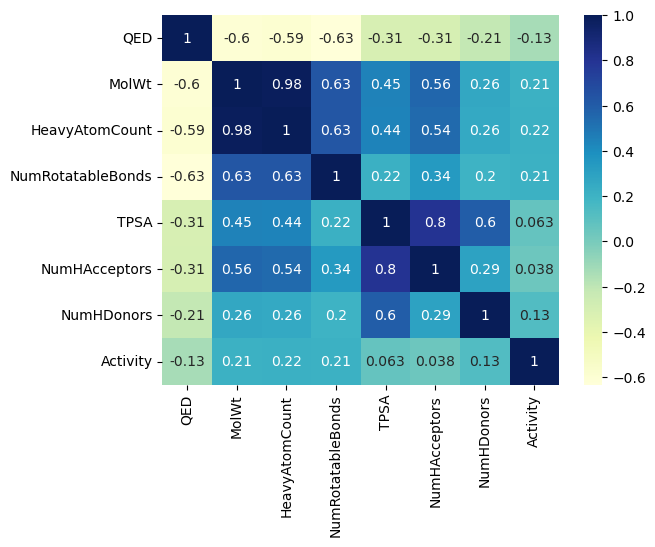

In [40]:
# plotting correlation heatmap
dataplot = sb.heatmap(dp_ACHE.corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
plt.show()

In [41]:
correlated_features_ACHE = set()

correlation_matrix_ACHE = dp_ACHE.corr()
correlation_matrix_ACHE

,QED,MolWt,HeavyAtomCount,NumRotatableBonds,TPSA,NumHAcceptors,NumHDonors,Activity
QED,1.000000,-0.603141,-0.593383,-0.633414,-0.308229,-0.305250,-0.212421,-0.134652
MolWt,-0.603141,1.000000,0.983781,0.626764,0.446974,0.555088,0.261228,0.210900
HeavyAtomCount,-0.593383,0.983781,1.000000,0.627171,0.442949,0.542427,0.258777,0.218734
NumRotatableBonds,-0.633414,0.626764,0.627171,1.000000,0.217495,0.339318,0.202368,0.208885
TPSA,-0.308229,0.446974,0.442949,0.217495,1.000000,0.798758,0.596922,0.062968
NumHAcceptors,-0.305250,0.555088,0.542427,0.339318,0.798758,1.000000,0.293942,0.038037
NumHDonors,-0.212421,0.261228,0.258777,0.202368,0.596922,0.293942,1.000000,0.126600
Activity,-0.134652,0.210900,0.218734,0.208885,0.062968,0.038037,0.126600,1.000000


In [42]:
for i in range(len(correlation_matrix_ACHE.columns)):
    for j in range(i):
        if abs(correlation_matrix_ACHE.iloc[i, j]) > 0.8:
            colname = correlation_matrix_ACHE.columns[i]
            correlated_features_ACHE.add(colname)

In [43]:
print(len(correlated_features_ACHE), correlated_features_ACHE)

1 {'HeavyAtomCount'}


## BACE

In [44]:
BACE.reset_index(inplace=True, drop=False)

In [45]:
smiles_bace = []

for i in range(len(BACE)):
    smiles_bace.append(BACE["Smiles_STAND"][i])

In [46]:
descritors = {'QED':[],'MolWt':[],'HeavyAtomCount':[], 'NumRotatableBonds':[], 'TPSA':[],
              'NumHAcceptors':[],'NumHDonors':[]}

In [47]:
for i in range(len(smiles_bace)):
    m = Chem.MolFromSmiles(smiles_bace[i])
    descritors['QED'].append(QED.default(m))
    descritors['MolWt'].append(MolWt(m))
    descritors['HeavyAtomCount'].append(Lipinski.HeavyAtomCount(m))
    descritors['NumRotatableBonds'].append(Lipinski.NumRotatableBonds(m))
    descritors['TPSA'].append(MolSurf.TPSA(m))
    descritors['NumHAcceptors'].append(Lipinski.NumHAcceptors(m))
    descritors['NumHDonors'].append(Lipinski.NumHDonors(m))

In [48]:
dp_BACE = pd.DataFrame(descritors)
dp_BACE

,QED,MolWt,HeavyAtomCount,NumRotatableBonds,TPSA,NumHAcceptors,NumHDonors
0,0.157234,591.750,42,17,188.95,8,6
1,0.082313,778.114,54,24,174.96,9,6
2,0.152968,636.900,44,19,145.86,8,5
3,0.144127,619.804,44,18,188.95,8,6
4,0.158828,654.871,45,18,180.00,9,5
...,...,...,...,...,...,...,...
8035,0.424239,487.441,36,2,93.70,6,1
8036,0.606267,499.572,35,5,135.16,8,2
8037,0.611343,482.585,34,3,131.09,6,3
8038,0.706905,429.427,31,5,111.72,7,2


In [49]:
dp_BACE= dp_BACE.assign(Activity=BACE['Activity'])
dp_BACE

,QED,MolWt,HeavyAtomCount,NumRotatableBonds,TPSA,NumHAcceptors,NumHDonors,Activity
0,0.157234,591.750,42,17,188.95,8,6,0.0
1,0.082313,778.114,54,24,174.96,9,6,0.0
2,0.152968,636.900,44,19,145.86,8,5,0.0
3,0.144127,619.804,44,18,188.95,8,6,0.0
4,0.158828,654.871,45,18,180.00,9,5,0.0
...,...,...,...,...,...,...,...,...
8035,0.424239,487.441,36,2,93.70,6,1,1.0
8036,0.606267,499.572,35,5,135.16,8,2,1.0
8037,0.611343,482.585,34,3,131.09,6,3,1.0
8038,0.706905,429.427,31,5,111.72,7,2,1.0


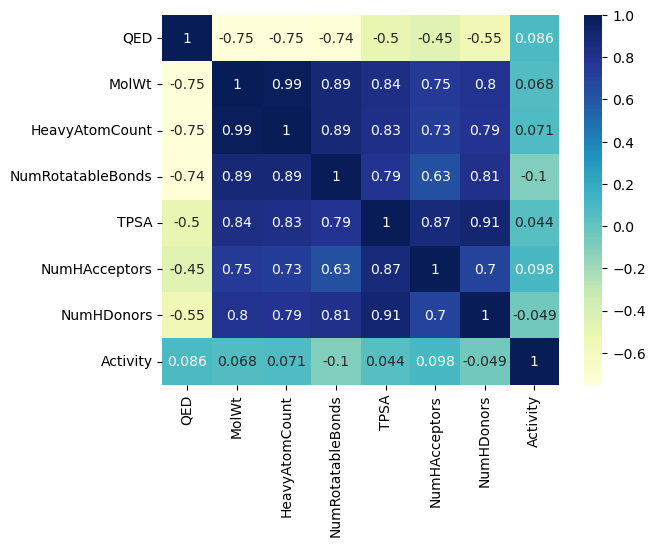

In [50]:
# plotting correlation heatmap
dataplot = sb.heatmap(dp_BACE.corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
plt.show()

In [51]:
correlated_features_BACE = set()

correlation_matrix_BACE = dp_BACE.corr()
correlation_matrix_BACE

,QED,MolWt,HeavyAtomCount,NumRotatableBonds,TPSA,NumHAcceptors,NumHDonors,Activity
QED,1.000000,-0.747397,-0.751337,-0.735571,-0.501746,-0.452560,-0.549462,0.085840
MolWt,-0.747397,1.000000,0.986812,0.885243,0.837649,0.749447,0.797815,0.067688
HeavyAtomCount,-0.751337,0.986812,1.000000,0.890199,0.826934,0.732418,0.785325,0.070627
NumRotatableBonds,-0.735571,0.885243,0.890199,1.000000,0.788791,0.631982,0.811089,-0.100880
TPSA,-0.501746,0.837649,0.826934,0.788791,1.000000,0.873773,0.909155,0.043990
NumHAcceptors,-0.452560,0.749447,0.732418,0.631982,0.873773,1.000000,0.700951,0.098333
NumHDonors,-0.549462,0.797815,0.785325,0.811089,0.909155,0.700951,1.000000,-0.048625
Activity,0.085840,0.067688,0.070627,-0.100880,0.043990,0.098333,-0.048625,1.000000


In [52]:
for i in range(len(correlation_matrix_BACE.columns)):
    for j in range(i):
        if abs(correlation_matrix_BACE.iloc[i, j]) > 0.8:
            colname_BACE = correlation_matrix_BACE.columns[i]
            correlated_features_BACE.add(colname_BACE)

In [53]:
print(len(correlated_features_BACE), correlated_features_BACE)

5 {'NumHAcceptors', 'TPSA', 'HeavyAtomCount', 'NumHDonors', 'NumRotatableBonds'}


## TAU

In [54]:
TAU.reset_index(inplace=True, drop=False)

In [55]:
smiles_tau = []

for i in range(len(TAU)):
    smiles_tau.append(TAU["Smiles_STAND"][i])

In [56]:
descritors = {'QED':[],'MolWt':[],'HeavyAtomCount':[], 'NumRotatableBonds':[], 'TPSA':[],
              'NumHAcceptors':[],'NumHDonors':[]}

In [57]:
for i in range(len(smiles_tau)):
    m = Chem.MolFromSmiles(smiles_tau[i])
    descritors['QED'].append(QED.default(m))
    descritors['MolWt'].append(MolWt(m))
    descritors['HeavyAtomCount'].append(Lipinski.HeavyAtomCount(m))
    descritors['NumRotatableBonds'].append(Lipinski.NumRotatableBonds(m))
    descritors['TPSA'].append(MolSurf.TPSA(m))
    descritors['NumHAcceptors'].append(Lipinski.NumHAcceptors(m))
    descritors['NumHDonors'].append(Lipinski.NumHDonors(m))

In [58]:
dp_TAU = pd.DataFrame(descritors)
dp_TAU

,QED,MolWt,HeavyAtomCount,NumRotatableBonds,TPSA,NumHAcceptors,NumHDonors
0,0.387190,356.381,27,4,63.45,3,0
1,0.618155,376.197,20,2,41.13,2,2
2,0.387190,356.381,27,4,63.45,3,0
3,0.800202,336.391,25,3,49.85,4,0
4,0.657127,355.441,27,4,36.44,3,0
...,...,...,...,...,...,...,...
165,0.554085,414.870,28,4,73.06,7,1
166,0.545623,419.289,27,3,63.83,6,1
167,0.496768,463.740,27,3,63.83,6,1
168,0.482342,375.580,28,8,6.25,1,0


In [59]:
dp_TAU= dp_TAU.assign(Activity=TAU['Activity'])
dp_TAU

,QED,MolWt,HeavyAtomCount,NumRotatableBonds,TPSA,NumHAcceptors,NumHDonors,Activity
0,0.387190,356.381,27,4,63.45,3,0,0.0
1,0.618155,376.197,20,2,41.13,2,2,0.0
2,0.387190,356.381,27,4,63.45,3,0,0.0
3,0.800202,336.391,25,3,49.85,4,0,0.0
4,0.657127,355.441,27,4,36.44,3,0,0.0
...,...,...,...,...,...,...,...,...
165,0.554085,414.870,28,4,73.06,7,1,1.0
166,0.545623,419.289,27,3,63.83,6,1,1.0
167,0.496768,463.740,27,3,63.83,6,1,1.0
168,0.482342,375.580,28,8,6.25,1,0,1.0


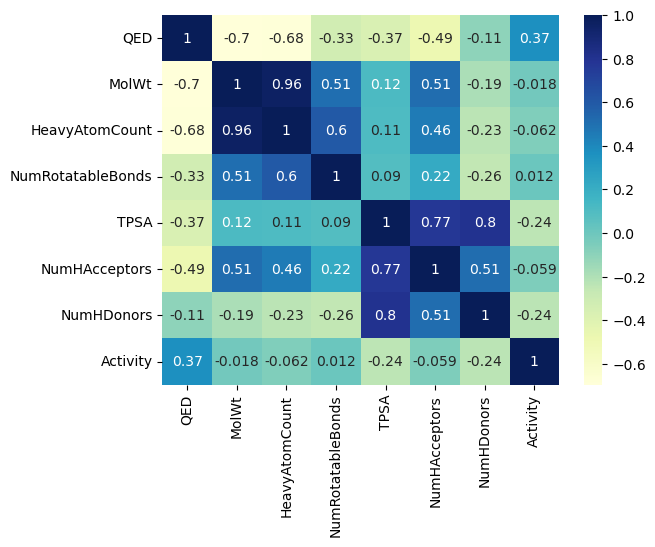

In [60]:
# plotting correlation heatmap
dataplot = sb.heatmap(dp_TAU.corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
plt.show()

In [61]:
correlated_features_TAU = set()

correlation_matrix_TAU = dp_TAU.corr()
correlation_matrix_TAU

,QED,MolWt,HeavyAtomCount,NumRotatableBonds,TPSA,NumHAcceptors,NumHDonors,Activity
QED,1.000000,-0.695209,-0.683197,-0.327183,-0.367774,-0.488322,-0.105656,0.369983
MolWt,-0.695209,1.000000,0.957404,0.505115,0.117395,0.510088,-0.186710,-0.017959
HeavyAtomCount,-0.683197,0.957404,1.000000,0.596620,0.106838,0.456126,-0.231998,-0.062390
NumRotatableBonds,-0.327183,0.505115,0.596620,1.000000,0.089572,0.223270,-0.257665,0.011543
TPSA,-0.367774,0.117395,0.106838,0.089572,1.000000,0.770681,0.803263,-0.242755
NumHAcceptors,-0.488322,0.510088,0.456126,0.223270,0.770681,1.000000,0.511084,-0.058538
NumHDonors,-0.105656,-0.186710,-0.231998,-0.257665,0.803263,0.511084,1.000000,-0.238257
Activity,0.369983,-0.017959,-0.062390,0.011543,-0.242755,-0.058538,-0.238257,1.000000


In [62]:
for i in range(len(correlation_matrix_TAU.columns)):
    for j in range(i):
        if abs(correlation_matrix_TAU.iloc[i, j]) > 0.8:
            colname_TAU = correlation_matrix_TAU.columns[i]
            correlated_features_TAU.add(colname_TAU)

In [63]:
print('ACHE:','N_correlated:', len(correlated_features_ACHE), ', descriptors:', correlated_features_ACHE)
print('BACE:','N_correlated:', len(correlated_features_BACE), ', descriptors:', correlated_features_BACE)
print('TAU:','N_correlated:', len(correlated_features_TAU), ', descriptors:', correlated_features_TAU)

ACHE: N_correlated: 1 , descriptors: {'HeavyAtomCount'}
BACE: N_correlated: 5 , descriptors: {'NumHAcceptors', 'TPSA', 'HeavyAtomCount', 'NumHDonors', 'NumRotatableBonds'}
TAU: N_correlated: 2 , descriptors: {'NumHDonors', 'HeavyAtomCount'}


## Eliminación de las features correlacionadas

In [64]:
dp_ACHE.drop(labels='HeavyAtomCount', axis=1, inplace=True)
dp_ACHE

,QED,MolWt,NumRotatableBonds,TPSA,NumHAcceptors,NumHDonors,Activity
0,0.488124,300.362,5,88.72,5,2,0.0
1,0.765195,312.482,5,6.48,3,0,0.0
2,0.392838,258.494,11,0.00,0,0,0.0
3,0.485768,275.352,5,64.93,4,2,0.0
4,0.234841,363.414,8,100.46,7,2,0.0
...,...,...,...,...,...,...,...
5143,0.630629,418.880,3,66.48,3,1,1.0
5144,0.586390,439.298,3,66.48,3,1,1.0
5145,0.669862,398.462,3,66.48,3,1,1.0
5146,0.661014,404.853,3,66.48,3,1,1.0


In [65]:
dp_ACHE.to_csv('Dp_ACHE.csv', sep=';')

In [66]:
dp_BACE.drop(labels='HeavyAtomCount', axis=1, inplace=True)
dp_BACE

,QED,MolWt,NumRotatableBonds,TPSA,NumHAcceptors,NumHDonors,Activity
0,0.157234,591.750,17,188.95,8,6,0.0
1,0.082313,778.114,24,174.96,9,6,0.0
2,0.152968,636.900,19,145.86,8,5,0.0
3,0.144127,619.804,18,188.95,8,6,0.0
4,0.158828,654.871,18,180.00,9,5,0.0
...,...,...,...,...,...,...,...
8035,0.424239,487.441,2,93.70,6,1,1.0
8036,0.606267,499.572,5,135.16,8,2,1.0
8037,0.611343,482.585,3,131.09,6,3,1.0
8038,0.706905,429.427,5,111.72,7,2,1.0


In [67]:
dp_BACE.to_csv('Dp_BACE.csv', sep=';')

In [68]:
dp_TAU.drop(labels='HeavyAtomCount', axis=1, inplace=True)
dp_TAU

,QED,MolWt,NumRotatableBonds,TPSA,NumHAcceptors,NumHDonors,Activity
0,0.387190,356.381,4,63.45,3,0,0.0
1,0.618155,376.197,2,41.13,2,2,0.0
2,0.387190,356.381,4,63.45,3,0,0.0
3,0.800202,336.391,3,49.85,4,0,0.0
4,0.657127,355.441,4,36.44,3,0,0.0
...,...,...,...,...,...,...,...
165,0.554085,414.870,4,73.06,7,1,1.0
166,0.545623,419.289,3,63.83,6,1,1.0
167,0.496768,463.740,3,63.83,6,1,1.0
168,0.482342,375.580,8,6.25,1,0,1.0


In [69]:
dp_TAU.to_csv('Dp_TAU.csv', sep=';')